# Predicting Project Funding on the DonorsChoose Dataset using Naive Bayes

DonorsChoose is a crowdfunding platform that connects teachers in need of educational resources with potential donors who are willing to support their projects. The DonorsChoose dataset contains information about these projects, including the project details, funding requests, and outcomes. The task is to predict whether a project will be successfully funded or not.

## 1.1 Loading Data

In [ ]:
# mount google drive to get the training data
import pandas
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# get the data to a variable
data = pandas.read_csv('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 8/Preprocessed_data.csv',\
                       nrows=50000)
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# import all the necessary modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from math import log
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from prettytable import PrettyTable # got prettytable codes from https://learnpython.com/blog/print-table-in-python/#:~:text=We'll%20use%20the%20PrettyTable,and%20print%20tables%20in%20Python.&text=For%20databases%20with%20a%20Python,from_db_cursor()%20function%20from%20prettytable%20.
from prettytable import ALL # "ALL" is to show line between rows in prettytable

In [ ]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [ ]:
# split the data and the class label columns
X = data.drop('project_is_approved',axis=1)
y = data['project_is_approved']

<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [ ]:
# split the training and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,stratify=y)

# initialize, fit and transform the TFIDF model for the "essay" feature
tfidf_essay = TfidfVectorizer(min_df=10,max_features=10000,ngram_range=(1,3))
tfidf_train_essay = tfidf_essay.fit_transform(X_train['essay'])
tfidf_test_essay = tfidf_essay.transform(X_test['essay'])

# initialize, fit and transform the CountVectorizer model for the "essay" feature
BoW_essay = CountVectorizer(min_df=10,max_features=10000,ngram_range=(1,3))
BoW_train_essay = BoW_essay.fit_transform(X_train['essay'])
BoW_test_essay = BoW_essay.transform(X_test['essay'])

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
# do one hot encoding for the categorical features using CountVectorizer
BoW_OHE_ss = CountVectorizer(min_df=1,binary=True)
ohe_train_school_state = BoW_OHE_ss.fit_transform(X_train['school_state'])
ohe_test_school_state = BoW_OHE_ss.transform(X_test['school_state'])

BoW_OHE_tp = CountVectorizer(min_df=1,binary=True)
ohe_train_teacher_prefix = BoW_OHE_tp.fit_transform(X_train['teacher_prefix'])
ohe_test_teacher_prefix = BoW_OHE_tp.transform(X_test['teacher_prefix'])

BoW_OHE_pgc = CountVectorizer(min_df=1,binary=True)
ohe_train_project_grade_category = BoW_OHE_pgc.fit_transform(X_train['project_grade_category'])
ohe_test_project_grade_category = BoW_OHE_pgc.transform(X_test['project_grade_category'])

BoW_OHE_cc = CountVectorizer(min_df=1,binary=True)
ohe_train_clean_categories = BoW_OHE_cc.fit_transform(X_train['clean_categories'])
ohe_test_clean_categories = BoW_OHE_cc.transform(X_test['clean_categories'])

BoW_OHE_cs = CountVectorizer(min_df=1,binary=True)
ohe_train_clean_subcategories = BoW_OHE_cs.fit_transform(X_train['clean_subcategories'])
ohe_test_clean_subcategories = BoW_OHE_cs.transform(X_test['clean_subcategories'])

In [ ]:
# do normalization for the continuous features
norm = Normalizer()

norm_train_price = norm.fit_transform(X_train['price'].values.reshape(1,-1))
norm_train_price = norm_train_price.reshape(-1,1)
norm_test_price = norm.fit_transform(X_test['price'].values.reshape(1,-1))
norm_test_price = norm_test_price.reshape(-1,1)

norm_train_teacher_number_of_previously_posted_projects = norm.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
norm_train_teacher_number_of_previously_posted_projects = norm_train_teacher_number_of_previously_posted_projects.reshape(-1,1)
norm_test_teacher_number_of_previously_posted_projects = norm.fit_transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
norm_test_teacher_number_of_previously_posted_projects = norm_test_teacher_number_of_previously_posted_projects.reshape(-1,1)

In [ ]:
# combine the transformed essay feature, one hot encoded categorical features and normalized continuous features for both set 1(BoW) and set 2(TFIDF)
final_X_train_BoW_essay = hstack((BoW_train_essay,ohe_train_school_state,ohe_train_teacher_prefix,\
                          ohe_train_project_grade_category,ohe_train_clean_categories,ohe_train_clean_subcategories,\
                          norm_train_price,norm_train_teacher_number_of_previously_posted_projects)).tocsr()

final_X_test_BoW_essay = hstack((BoW_test_essay,ohe_test_school_state,ohe_test_teacher_prefix,\
                         ohe_test_project_grade_category,ohe_test_clean_categories,ohe_test_clean_subcategories,\
                         norm_test_price,norm_test_teacher_number_of_previously_posted_projects)).tocsr()

final_X_train_tfidf_essay = hstack((tfidf_train_essay,ohe_train_school_state,ohe_train_teacher_prefix,\
                            ohe_train_project_grade_category,ohe_train_clean_categories,ohe_train_clean_subcategories,\
                            norm_train_price,norm_train_teacher_number_of_previously_posted_projects)).tocsr()

final_X_test_tfidf_essay = hstack((tfidf_test_essay,ohe_test_school_state,ohe_test_teacher_prefix,\
                           ohe_test_project_grade_category,ohe_test_clean_categories,ohe_test_clean_subcategories,\
                           norm_test_price,norm_test_teacher_number_of_previously_posted_projects)).tocsr()

<h2>1.5 Appling NB on different kind of featurizations</h2>

In [ ]:
# initialize Naive Bayes feature
nb = MultinomialNB()

In [ ]:
# initialize parameters and GridsearchCV
params = {'alpha':[0.00001,0.0005,0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
search = GridSearchCV(estimator=nb, param_grid=params, scoring='roc_auc', cv=3,return_train_score=True)

#### Set 1

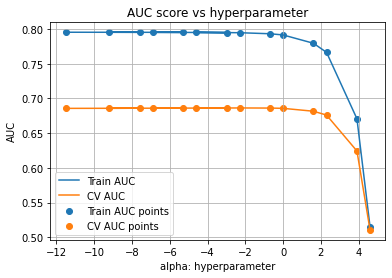

In [ ]:
# fit the data in GridsearchCV to search for best alpha and best train and test score
GS_out_BoW = search.fit(final_X_train_BoW_essay.toarray(),y_train)
Train_scores = GS_out_BoW.cv_results_['mean_train_score']
CV_scores = GS_out_BoW.cv_results_['mean_test_score']

param_values = params.get('alpha')
param_values = [log(i) for i in param_values]

# plot hyperparameter vs AUC score
plt.plot(param_values, Train_scores, label='Train AUC')
plt.plot(param_values, CV_scores, label='CV AUC')

plt.scatter(param_values, Train_scores, label='Train AUC points')
plt.scatter(param_values, CV_scores, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC score vs hyperparameter")
plt.grid()
plt.show()

In [ ]:
# print GridsearchCV results
print('BoW Model: ')
print('Best params- ',GS_out_BoW.best_params_)
print('Best score- ',GS_out_BoW.best_score_)

# create list to store the test results and append results of GridsearchCV
scores = [['Vectorizer','Model','train/test','Hyper parameter','AUC']]
scores.append(['BoW', 'Naive Bayes', 'train', GS_out_BoW.best_params_.get('alpha'), max(Train_scores)])
scores.append(['BoW', 'Naive Bayes', 'test', GS_out_BoW.best_params_.get('alpha'), GS_out_BoW.best_score_])

BoW Model: 
Best params-  {'alpha': 0.1}
Best score-  0.6862529076094885


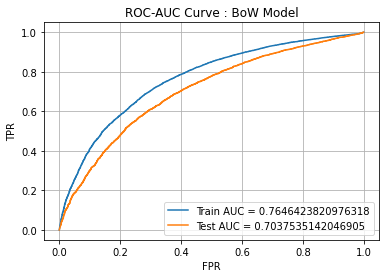

In [ ]:
# ROC-AUC curve - idea got from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# run the Naive Bayes model with the best value for alpha got from GridsearchCV
nb_BoW = MultinomialNB(alpha=GS_out_BoW.best_params_.get('alpha'),class_prior=[0.5,0.5])
nb_BoW.fit(final_X_train_BoW_essay.toarray(),y_train)

# get predicted probabilities from the Naive Bayes model for both training and test data
BoW_probs_trn = nb_BoW.predict_proba(final_X_train_BoW_essay.toarray())
BoW_probs_trn = BoW_probs_trn[:,1]
BoW_probs_tst = nb_BoW.predict_proba(final_X_test_BoW_essay.toarray())
BoW_probs_tst = BoW_probs_tst[:,1]

# get training and test AUC scores
trn_auc = 'Train AUC = ' + str(roc_auc_score(y_train,BoW_probs_trn))
tst_auc = 'Test AUC = ' + str(roc_auc_score(y_test,BoW_probs_tst))

# get FPR and TPR values for both train and test data for the Countvectorizer model
fpr_B_trn, tpr_B_trn, thrsh_B_trn = roc_curve(y_train,BoW_probs_trn)
fpr_B_tst, tpr_B_tst, thrsh_B_tst = roc_curve(y_test,BoW_probs_tst)

# plot the ROC-AUC curve for the Countvectorizer model
plt.plot(fpr_B_trn,tpr_B_trn,label=trn_auc)
plt.plot(fpr_B_tst,tpr_B_tst,label=tst_auc)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-AUC Curve : BoW Model')
plt.legend()
plt.grid()
plt.show()

Confusion Matrix - BoW Model: 


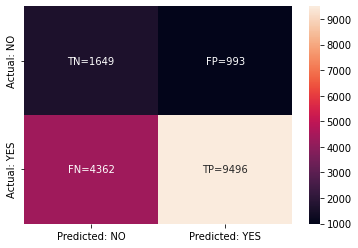

In [ ]:
# plot the confusion matrix for the Countvectorizer model using heatmap
print('Confusion Matrix - BoW Model: ')
pred_BoW = nb_BoW.predict(final_X_test_BoW_essay.toarray())
scores_B = confusion_matrix(y_test,pred_BoW)
txt = np.array([['TN='+str(scores_B[0][0]),'FP='+str(scores_B[0][1])],['FN='+str(scores_B[1][0]),'TP='+str(scores_B[1][1])]])
sns.heatmap(scores_B,fmt='',annot=txt,xticklabels=['Predicted: NO','Predicted: YES'],yticklabels=['Actual: NO','Actual: YES'])
plt.show()

#### Set 2

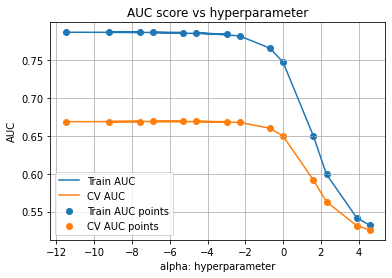

In [ ]:
# fit the data in GridsearchCV to search for best alpha and best train and test score
GS_out_tfidf = search.fit(final_X_train_tfidf_essay.toarray(),y_train)
Train_scores = GS_out_tfidf.cv_results_['mean_train_score']
CV_scores = GS_out_tfidf.cv_results_['mean_test_score']

param_values = params.get('alpha')
param_values = [log(i) for i in param_values]

# plot hyperparameter vs AUC score
plt.plot(param_values, Train_scores, label='Train AUC')
plt.plot(param_values, CV_scores, label='CV AUC')

plt.scatter(param_values, Train_scores, label='Train AUC points')
plt.scatter(param_values, CV_scores, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC score vs hyperparameter")
plt.grid()
plt.show()

In [ ]:
# print GridsearchCV results
print('TFIDF Model: ')
print('Best params- ',GS_out_tfidf.best_params_)
print('Best score- ',GS_out_tfidf.best_score_)

# create list to store the test results and append results of GridsearchCV
scores.append(['TFIDF', 'Naive Bayes', 'train', GS_out_tfidf.best_params_.get('alpha'), max(Train_scores)])
scores.append(['TFIDF', 'Naive Bayes', 'test', GS_out_tfidf.best_params_.get('alpha'), GS_out_tfidf.best_score_])

TFIDF Model: 
Best params-  {'alpha': 0.01}
Best score-  0.6692150207492444


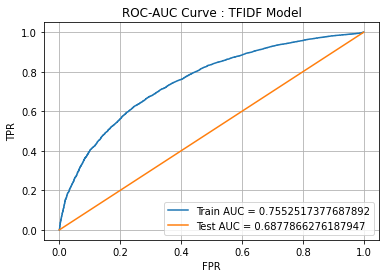

In [ ]:
# ROC-AUC curve - idea got from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# run the Naive Bayes model with the best value for alpha got from GridsearchCV
nb_tfidf = MultinomialNB(alpha=GS_out_tfidf.best_params_.get('alpha'),class_prior=[0.5,0.5])
nb_tfidf.fit(final_X_train_tfidf_essay.toarray(),y_train)

# get predicted probabilities from the Naive Bayes model for both training and test data
tfidf_probs_trn = nb_tfidf.predict_proba(final_X_train_tfidf_essay.toarray())
tfidf_probs_trn = tfidf_probs_trn[:,1]
tfidf_probs_tst = nb_tfidf.predict_proba(final_X_test_tfidf_essay.toarray())
tfidf_probs_tst = tfidf_probs_tst[:,1]

# get training and test AUC scores
trn_auc = 'Train AUC = ' + str(roc_auc_score(y_train,tfidf_probs_trn))
tst_auc = 'Test AUC = ' + str(roc_auc_score(y_test,tfidf_probs_tst))

# get FPR and TPR values for both train and test data for the TFIDF model
fpr_T_trn, tpr_T_trn, thrsh_T_trn = roc_curve(y_train,tfidf_probs_trn)
fpr_T_tst, tpr_T_tst, thrsh_T_tst = roc_curve(y_test,tfidf_probs_tst)

# plot the ROC-AUC curve for the TFIDF model
plt.plot(fpr_T_trn,tpr_T_trn,label=trn_auc)
plt.plot(fpr_T_tst,fpr_T_tst,label=tst_auc)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-AUC Curve : TFIDF Model')
plt.grid()
plt.legend()
plt.show()

Confusion Matrix - TFIDF Model: 


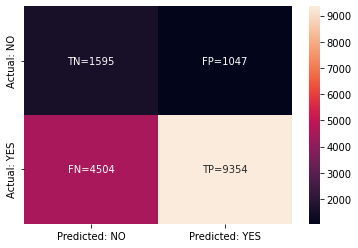

In [ ]:
# plot the confusion matrix for the TFIDF model using heatmap
print('Confusion Matrix - TFIDF Model: ')
pred_tfidf = nb_tfidf.predict(final_X_test_tfidf_essay.toarray())
scores_T = confusion_matrix(y_test,pred_tfidf)
txt = np.array([['TN='+str(scores_T[0][0]),'FP='+str(scores_T[0][1])],['FN='+str(scores_T[1][0]),'TP='+str(scores_T[1][1])]])
sns.heatmap(scores_T,fmt='',annot=txt,xticklabels=['Predicted: NO','Predicted: YES'],yticklabels=['Actual: NO','Actual: YES'])
plt.show()

<h1>3. Summary</h1>

In [ ]:
# get feature importance for the Countvectorizer model : +ve class
imp_feature_list_p = nb_BoW.feature_log_prob_[1]
imp_feature_list_p = np.argsort(-imp_feature_list_p)
imp_feature_list_p = imp_feature_list_p[0:20]

feature_names_p = []
feature_names_p.extend(BoW_essay.get_feature_names())
feature_names_p.extend(BoW_OHE_ss.get_feature_names())
feature_names_p.extend(BoW_OHE_tp.get_feature_names())
feature_names_p.extend(BoW_OHE_pgc.get_feature_names())
feature_names_p.extend(BoW_OHE_cc.get_feature_names())
feature_names_p.extend(BoW_OHE_cs.get_feature_names())
feature_names_p.append('price')
feature_names_p.append('teacher_number_of_previously_posted_projects')

# get the top 20 features
top_20_features_p = [feature_names_p[i] for i in imp_feature_list_p]
print("Top 20 features - +ve class:\n",top_20_features_p)

# get feature importance for the Countvectorizer model : -ve class
imp_feature_list_n = nb_BoW.feature_log_prob_[0]
imp_feature_list_n = np.argsort(-imp_feature_list_n)
imp_feature_list_n = imp_feature_list_n[0:20]

feature_names_n = []
feature_names_n.extend(BoW_essay.get_feature_names())
feature_names_n.extend(BoW_OHE_ss.get_feature_names())
feature_names_n.extend(BoW_OHE_tp.get_feature_names())
feature_names_n.extend(BoW_OHE_pgc.get_feature_names())
feature_names_n.extend(BoW_OHE_cc.get_feature_names())
feature_names_n.extend(BoW_OHE_cs.get_feature_names())
feature_names_n.append('price')
feature_names_n.append('teacher_number_of_previously_posted_projects')

# get the top 20 features
top_20_features_n = [feature_names_n[i] for i in imp_feature_list_n]
print("Top 20 features - -ve class:\n",top_20_features_n)

Top 20 features - +ve class:
 ['students', 'school', 'my', 'classroom', 'learning', 'the', 'not', 'they', 'learn', 'my students', 'help', 'many', 'nannan', 'we', 'work', 'reading', 'need', 'use', 'day', 'able']
Top 20 features - -ve class:
 ['students', 'school', 'learning', 'my', 'classroom', 'not', 'learn', 'they', 'help', 'the', 'my students', 'many', 'nannan', 'we', 'need', 'work', 'come', 'year', 'able', 'love']


In [ ]:
# get the scores in the prettytable
output_table = PrettyTable(scores[0])
output_table.add_rows(scores[1:])
output_table.hrules = ALL
print(output_table)

+------------+-------------+------------+-----------------+--------------------+
| Vectorizer |    Model    | train/test | Hyper parameter |        AUC         |
+------------+-------------+------------+-----------------+--------------------+
|    BoW     | Naive Bayes |   train    |       0.1       | 0.795296368710955  |
+------------+-------------+------------+-----------------+--------------------+
|    BoW     | Naive Bayes |    test    |       0.1       | 0.6862529076094885 |
+------------+-------------+------------+-----------------+--------------------+
|   TFIDF    | Naive Bayes |   train    |       0.01      | 0.7868956325948097 |
+------------+-------------+------------+-----------------+--------------------+
|   TFIDF    | Naive Bayes |    test    |       0.01      | 0.6692150207492444 |
+------------+-------------+------------+-----------------+--------------------+


#### Observations:
- the BoW model is performing slightly better than the TFIDF model
- The AUC score is lower for the test set as compared to the train set. This shows that there is some sort of overfitting in the model
- The top 4 important features for both the +ve and -ve classes are - 'students', 'school', 'my', 'classroom', 'learning'
- We used only 45% of the total data available and restricted maximum features in "essay" feature to 10,000 which is only 20% of the total features. If we considered the whole data, we would get a better result